In [37]:
import numpy as np
import pandas as pd
import yfinance as yf
import pandas_datareader.data as web
import scipy.stats as stats
import matplotlib.pyplot as plt
from numpy import random

import particles
import particles.state_space_models as ssm
import particles.distributions as dists
from particles import collectors
from particles import multiSMC
import particles.mcmc as mcmc
import particles.smc_samplers as ssp

In [38]:
#pip install particles

This notebook focuses on the study and replication of the results from the linked research paper using S&P 500 data, through the implementation of a bootstrap filter and an adaptive PMMH algorithm for parameter estimation.

We will conduct a returns-only study as no reliable option data was available for this analysis.

## Data and Implement SVCJ Model

The dataset is constructed by retrieving daily S&P 500 price levels and 3-month Treasury Bill rates from Yahoo Finance and FRED, covering the 1996-2015 period with a standard assumption of 252 trading days per year.

In [39]:
SP500_TICKER = '^GSPC'
FRED_TICKER = 'DTB3'

start_date = '1996-01-01'
end_date = '2015-12-31'

Trad_days_year = 252

In [40]:
data_SP500 = yf.download(SP500_TICKER, start=start_date, end=end_date, progress=False)
rf_data = web.DataReader(FRED_TICKER, 'fred', start=start_date, end=end_date)

C:\Users\bouch\AppData\Local\Temp\ipykernel_21864\1254190739.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_SP500 = yf.download(SP500_TICKER, start=start_date, end=end_date, progress=False)


Selection of closing prices renamed as $S_t$ to align with the model's notation, and computation of daily log-returns $R_t = \ln(S_t / S_{t-1})$.

In [ ]:
data_SP500 = data_SP500[['Close']]
data_SP500.columns = ['S_t']
data_SP500['R_t'] = np.log(data_SP500['S_t']/data_SP500['S_t'].shift(1))#log-return

,S_t,R_t
Date,,
1996-01-02,620.729980,NaN
1996-01-03,621.320007,0.000950
1996-01-04,617.700012,-0.005843
1996-01-05,616.710022,-0.001604
1996-01-08,618.460022,0.002834
...,...,...
2015-12-23,2064.290039,0.012342
2015-12-24,2060.989990,-0.001600
2015-12-28,2056.500000,-0.002181


Null values are filled using the previous day's risk-free rate (forward fill). For the specific case of January 1st, 1996, the value is imputed using the subsequent day's rate (backward fill) due to the absence of prior data.

In [ ]:
rf_data['DTB3'] = rf_data['DTB3'].fillna(method='ffill')
rf_data.loc['1996-01-01 00:00:00','DTB3'] = rf_data.loc['1996-01-02 00:00:00','DTB3']
rf_data.columns = ['rf_t']
rf_data['rf_t'] = rf_data['rf_t']/(100)


C:\Users\bouch\AppData\Local\Temp\ipykernel_21864\1605616683.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rf_data['DTB3'] = rf_data['DTB3'].fillna(method='ffill')


Inner join on dates and removal of remaining NaNs to ensure a synchronized dataset.

In [ ]:
data_return_based = pd.merge(rf_data, data_SP500, left_index=True, right_index=True, how='inner')
data_return_based = data_return_based.dropna()

,rf_t,S_t,R_t
1996-01-03,0.0505,621.320007,0.000950
1996-01-04,0.0504,617.700012,-0.005843
1996-01-05,0.0503,616.710022,-0.001604
1996-01-08,0.0503,618.460022,0.002834
1996-01-09,0.0501,609.450012,-0.014676
...,...,...,...
2015-12-23,0.0020,2064.290039,0.012342
2015-12-24,0.0020,2060.989990,-0.001600
2015-12-28,0.0023,2056.500000,-0.002181
2015-12-29,0.0023,2078.360107,0.010574


**Discretized SVCJ Model Summary**

The Stochastic Volatility with Correlated Jumps (SVCJ) model is implemented using the Euler discretization scheme, defining the dynamics for the observed log-return ($R_{t+1}$) and the latent spot variance ($V_{t+1}$).

1. Log-Return Equation (Observation Density $f_1$)

The observed log-return is used as the measurement density in the Particle Filter:

$$
R_{t+1} = r_t - \delta_t - \frac{V_t}{2} + \eta_s V_t - \lambda \bar{\mu}_s + \sqrt{V_t}z_{t+1} + J^s_{t+1} B_{t+1}
$$

Components:
- $R_{t+1}$: Observed log-return ($\ln(S_{t+1}/S_t)$).
- $V_t$: Latent spot variance at time $t$.
- $r_t - \delta_t - \dots$: Total drift component.
- $\sqrt{V_t}z_{t+1}$: Continuous diffusion term ($z_{t+1} \sim \mathcal{N}(0, 1)$).
- $J^s_{t+1} B_{t+1}$: Discrete price jump ($B_{t+1} \sim \text{Bernoulli}(\lambda \Delta t)$).

2. Variance Equation

The spot variance evolves according to the transition density:

$$
V_{t+1} - V_t = \kappa(\theta - V_t) + \sigma \sqrt{V_t}w_{t+1} + J^v_{t+1} B_{t+1}
$$

Components:
- $V_{t+1} - V_t$: Change in spot variance ($\Delta V_t$).
- $\kappa(\theta - V_t)$: Mean-reversion component ($\kappa$: speed, $\theta$: long-term mean).
- $\sigma \sqrt{V_t}w_{t+1}$: Vol-of-Vol diffusion ($\sigma$: volatility of volatility, $w_{t+1} \sim \mathcal{N}(0, 1)$, correlated with $z_{t+1}$ by $\rho$).
- $J^v_{t+1} B_{t+1}$: Discrete variance jump.


**Variable Definitions for SVCJ Bootstrap Filter**

**Data Variables**

- ($R_t$): Observed Log-Return. The daily logarithmic return of the asset, calculated as $\ln(S_t/S_{t-1})$.

- ($r_t$): Risk-Free Rate. The annualized risk-free interest rate corresponding to each observation day.

**Model Parameters**

- ($\kappa$): Mean Reversion Speed. Determines how quickly the variance returns to its long-term mean.
- ($\theta$): Long-Run Variance. The steady-state level of the variance process.
- ($\sigma$): Volatility of Volatility. Controls the magnitude of the random fluctuations in the variance process.
- ($\rho$): Brownian Correlation. The correlation between the price diffusion and variance diffusion (Leverage Effect).
- ($\eta_s$): Volatility Risk Premium. A parameter adjusting the drift to account for volatility risk.
- ($\lambda$): Jump Intensity. The expected number of jump events per year.
- ($\mu_s$): Mean Price Jump. The average magnitude of a jump in the log-price (typically negative).
- ($\sigma_s$): Price Jump Standard Deviation. The uncertainty or variability associated with the size of the price jump.
- ($\mu_v$): Mean Variance Jump. The average size of the upward jump in variance.
- ($\rho_J$): Jump Correlation. The correlation between the size of the price jump and the size of the variance jump.
- ($\delta$): Dividend Yield. The annualized dividend rate, fixed to 0.0 for this estimation.

In [47]:
class SVCJ_Transition:
    def __init__(self, V_prev, dt, params):
        self.V_prev = V_prev
        self.dt = dt
        self.p = params

    def rvs(self, size=None):
        N = len(self.V_prev)
        dt, p = self.dt, self.p

        # 1. Shocks (Appendix B - Step 1)
        w = np.random.normal(size=N)
        prob_jump = np.clip(p.lbd * dt, 1e-12, 1.0 - 1e-12)
        B = np.random.binomial(1, prob_jump, size=N)
        J_v = np.random.exponential(scale=p.mu_v, size=N)
        # Js correlation via rho_j (Note 33)
        J_s = np.random.normal(loc=p.mu_s + p.rho_j * J_v, scale=p.sigma_s, size=N)

        # 2. Variance Dynamics (Equation 7 - Euler Scheme)
        v_safe = np.maximum(self.V_prev, 1e-12)
        mean_rev = p.kappa * (p.theta - self.V_prev) * dt
        # dW_t = w * sqrt(dt)
        diffusion = p.sigma * np.sqrt(v_safe * dt) * w 
        jump_vol = J_v * B

        V_next = self.V_prev + mean_rev + diffusion + jump_vol

        # 3. Augmented State [V, w, Jv, B, Js]
        res = np.zeros((N, 5))
        res[:, 0] = np.maximum(V_next, 1e-12)
        res[:, 1] = w
        res[:, 2] = J_v
        res[:, 3] = B
        res[:, 4] = J_s
        return res

class SVCJ_Observation:
    def __init__(self, xp, x, r_f_t, dt, params):
        # xp is None at t=0
        self.xp = x if xp is None else xp 
        self.x = x
        self.r_f_t = r_f_t # Risk-free rate for the current period
        self.dt = dt
        self.p = params

        # Jump compensator mu_bar_s (Equation B.3)
        num = np.exp(params.mu_s + 0.5 * params.sigma_s**2)
        den = 1.0 - params.rho_j * params.mu_v
        self.mu_bar_s = (num / den) - 1.0

    def _compute_moments(self):
        p, dt = self.p, self.dt

        # Indices: 0:V, 1:w, 2:Jv, 3:B, 4:Js
        v_prev = self.xp[:, 0]
        w_curr = self.x[:, 1]
        b_curr = self.x[:, 3]
        js_curr = self.x[:, 4]

        v_safe = np.maximum(v_prev, 1e-12)

        # 1. Drift according to Equation 6 (B.3)
        # Using the specific risk-free rate r_f_t
        drift = (self.r_f_t - p.delta - 0.5 * v_safe + p.eta_s * v_safe - p.lbd * self.mu_bar_s) * dt
        
        # 2. Conditional Mean (Leverage rho included via w_curr)
        mean_cond = drift + p.rho * np.sqrt(v_safe * dt) * w_curr + b_curr * js_curr
        
        # 3. Conditional Volatility (Idiosyncratic)
        vol_cond = np.sqrt(np.maximum(v_safe * dt * (1.0 - p.rho**2), 1e-12))

        return mean_cond, vol_cond

    def logpdf(self, y_obs):
        mean_cond, vol_cond = self._compute_moments()
        return np.nan_to_num(stats.norm.logpdf(y_obs, loc=mean_cond, scale=vol_cond), nan=-1e5)

    def rvs(self, size=None):
        mean_cond, vol_cond = self._compute_moments()
        return stats.norm.rvs(loc=mean_cond, scale=vol_cond, size=size)

class SVCJ_Model(ssm.StateSpaceModel):
    def __init__(self, r_vec, dt=1/252.0, **kwargs):
        super().__init__(**kwargs)
        self.r_vec = r_vec # Risk-free rates vector
        self.dt = dt
        self.dim = 5 # V, w, Jv, B, Js

        for key, value in kwargs.items():
            setattr(self, key, value)

    def PX0(self):
        return dists.IndepProd(
            dists.LogNormal(np.log(self.theta), 0.1),
            dists.Dirac(0.0), # w
            dists.Dirac(0.0), # Jv
            dists.Dirac(0.0), # B
            dists.Dirac(0.0)  # Js
        )

    def PX(self, t, xp):
        return SVCJ_Transition(V_prev=xp[:, 0], dt=self.dt, params=self)

    def PY(self, t, xp, x):
        # We pass the risk-free rate r_vec[t] to the observation
        return SVCJ_Observation(xp=xp, x=x, r_f_t=self.r_vec[t], dt=self.dt, params=self)

## Bootstrap

First let's fix the parameters using the parameters estimate with the returns by the article

In [48]:
annuals_fixed_params = {
    'kappa':  7.4387,
    'theta':  0.0244,
    'sigma':  0.4387,
    'rho':   -0.8232,
    'eta_s':  3.2508,
    'lbd': 0.8128,
    'mu_s':  -0.0261,
    'sigma_s': 0.0221,
    'mu_v':   0.0822,
    'rho_j': -0.0960,
    'delta':  0.0
}

In [49]:
data_y = data_return_based['R_t'].values
r_vector = data_return_based['rf_t'].values
dt = 1/252.0

We implement a Bootstrap Particle Filter utilizing $N=20,000$ particles to estimate the model's marginal likelihood and latent states. The model parameters are strictly calibrated using the empirical estimates provided in Table A1 of the reference article, while the discretization follows a daily time step of $\Delta t = 1/252$.The choice of systematic resampling is driven by the need to minimize weight variance and maximize computational efficiency, as it offers a more stable particle distribution than standard multinomial sampling. Furthermore, the ESSrmin threshold is set to 0.5, ensuring that resampling only occurs when the Effective Sample Size drops by 50%. This strategy effectively preserves particle diversity and mitigates the risk of particle depletion during periods of high market stress.

In [51]:
model = SVCJ_Model(r_vec=r_vector, dt=dt, **annuals_fixed_params)
fk_model = ssm.Bootstrap(ssm=model, data=data_y)
n_particles = 20000
pf_SVCJ = particles.SMC(
    fk=fk_model, N=n_particles,
    resampling='systematic',
    ESSrmin=0.5,
    store_history=False,
    collect=[collectors.Moments()])
pf_SVCJ.run()

In [ ]:
log_likelihood = pf_SVCJ.logLt
print(f"Estimated Marginal Log-Likelihood (log L_T): {log_likelihood:.4f}")

Log-Vraisemblance Marginale Estimée (log L_T): 16160.9517


Our estimated log-likelihood of 16,160.95 is very close to the 16,149 reported in Table A1, confirming the accuracy of our SVCJ model implementation and particle filter.

Volatility Filtering: SVCJ vs Realized Volatility Benchmark

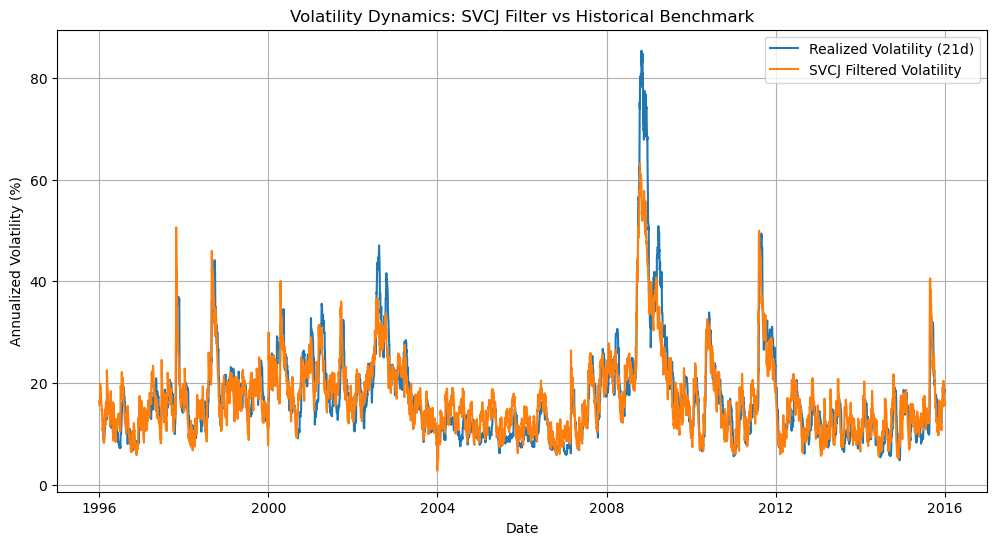

In [53]:
# Benchmark: Realized Volatility Estimation

TRADING_DAYS = 252
WINDOW = 21
daily_vol = data_return_based['R_t'].rolling(window=WINDOW).std()
rv_annualized = daily_vol * np.sqrt(TRADING_DAYS) * 100
df_rv = pd.DataFrame({'RV': rv_annualized.dropna()})

# Model: SVCJ Filtered Volatility Extraction
# Extracting latent variance state E[V_t | Y_{1:t}] from particle history
filtered_var = np.array([m['mean'][0] for m in pf_SVCJ.summaries.moments])
svcj_vol = np.sqrt(filtered_var) * 100
svcj_dates = data_return_based['R_t'].index[-len(svcj_vol):]

# Visualization
plt.figure(figsize=(12, 6))

# Benchmark
plt.plot(df_rv.index, df_rv['RV'], label=f'Realized Volatility ({WINDOW}d)')

# Model Output
plt.plot(svcj_dates, svcj_vol, label='SVCJ Filtered Volatility')


plt.title('Volatility Dynamics: SVCJ Filter vs Historical Benchmark')
plt.ylabel('Annualized Volatility (%)')
plt.xlabel('Date')
plt.legend()
plt.grid()
plt.show()

The plot shows a strong alignment between the two measures, although the SVCJ Filtered Volatility tends to underestimate peak volatility during the 2002 market downturn and the 2008–2009 Subprime crisis. While the model captures the timing of market stress, the extreme magnitude of realized volatility during these systemic crashes suggests the filter's latent state expectations were lower than the historical spikes.

We run the filter 20 times with 30,000 particles to measure the variance of our log-likelihood estimator. This step is critical to ensure that numerical noise is sufficiently low for stable MCMC calibration, as a high variance would lead to poor convergence in the PMMH algorithm.

In [54]:
# Parameters for variance estimation
n_runs = 20
n_particles_test = 30000

# Parallel execution for efficiency
results = multiSMC(
    fk=fk_model,
    N=n_particles_test,
    nruns=n_runs,
    nprocs=0,
    resampling='systematic',
    ESSrmin=0.5,
    store_history=False,
    out_func=lambda pf: pf.logLt  # Direct extraction
)

# Retrieve LogLikelihoods from output dict
log_likelihoods = [res['output'] for res in results]

# Compute statistics
mean_ll_SVCJ = np.mean(log_likelihoods)
std_dev_SVCJ = np.std(log_likelihoods)

print(f"Mean LogLt SV: {mean_ll_SVCJ:.4f}")
print(f"Std Dev SV:    {std_dev_SVCJ:.4f}")
print(f"Var SV:    {std_dev_SVCJ**2:.4f}")

Mean LogLt SV: 16160.8222
Std Dev SV:    2.2402
Var SV:    5.0186


The variance of 5.02 with 30,000 particles is significantly higher than the recommended $\text{Var} \ll 1$, indicating that the PMMH will likely suffer from numerical noise and a "sticky" chain.

Let's try with a SV model

In [55]:
annuals_fixed_SV_params = {
    "kappa": 6.4802,
    "theta": 0.0339,
    "sigma": 0.5121,
    "rho": -0.7886,
    "eta_s": 2.3818,
    # SVCJ params set to 0.0 to collapse into SV model
    "mu_s": 0.0,
    "sigma_s": 0.0,
    "lbd": 0.0,
    "mu_v": 0.0,
    "rho_j": 0.0,
    "delta": 0.0
}

In [56]:
model_SV = SVCJ_Model(r_vec=r_vector, dt=dt, **annuals_fixed_SV_params)
fk_model_SV = ssm.Bootstrap(ssm=model_SV, data=data_y)
n_particles = 20000
pf_SV = particles.SMC(
    fk=fk_model_SV,
    N=n_particles,
    resampling='systematic',
    ESSrmin=0.5,
    store_history=False,
    collect=[collectors.Moments()]
)
pf_SV.run()

In [57]:
log_likelihood_SV = pf_SV.logLt
print(f"Log-Vraisemblance Marginale Estimée (log L_T): {log_likelihood_SV:.4f}")

Log-Vraisemblance Marginale Estimée (log L_T): 16133.4122


Our estimated log-likelihood for the SV model is 16,133.41, which is very close to the 16,122 reported in Table A1, confirming that the SV specification is also correctly calibrated and implemented.

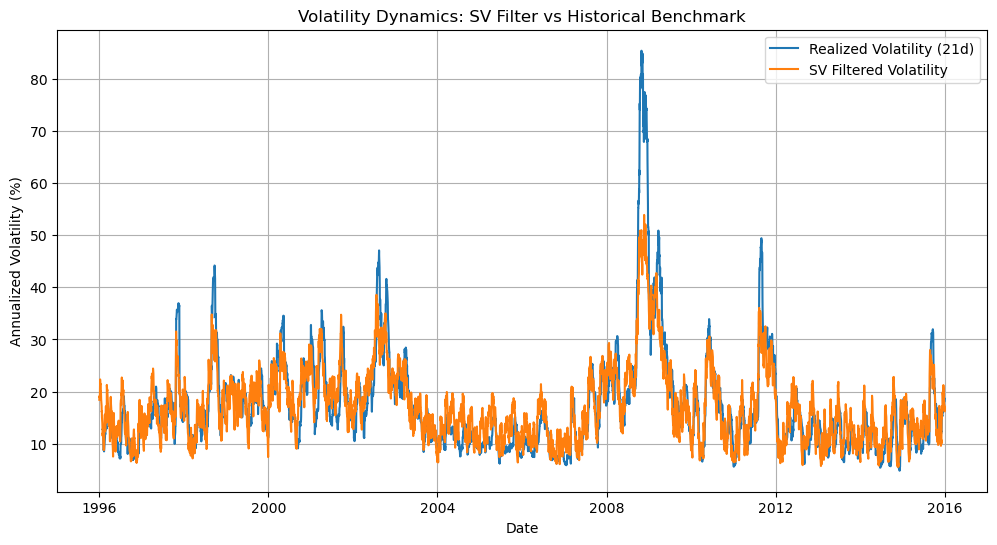

In [58]:
# Benchmark: Realized Volatility Estimation

TRADING_DAYS = 252
WINDOW = 21
daily_vol = data_return_based['R_t'].rolling(window=WINDOW).std()
rv_annualized = daily_vol * np.sqrt(TRADING_DAYS) * 100
df_rv = pd.DataFrame({'RV': rv_annualized.dropna()})

# Model: SV Filtered Volatility Extraction
filtered_var = np.array([m['mean'][0] for m in pf_SV.summaries.moments])
sv_vol = np.sqrt(filtered_var) * 100
sv_dates = data_return_based['R_t'].index[-len(sv_vol):]

# Visualization
plt.figure(figsize=(12, 6))

# Benchmark
plt.plot(df_rv.index, df_rv['RV'], label=f'Realized Volatility ({WINDOW}d)')

# Model Output
plt.plot(sv_dates, sv_vol, label='SV Filtered Volatility')


plt.title('Volatility Dynamics: SV Filter vs Historical Benchmark')
plt.ylabel('Annualized Volatility (%)')
plt.xlabel('Date')
plt.legend()
plt.grid()
plt.show()

The SV Filtered Volatility effectively follows the general market trends, but systematically underestimates extreme spikes. Without jump components, the model relies purely on continuous diffusion, which lacks the reactivity needed to capture the full magnitude of rapid volatility surges during crises.

In [59]:
# Parameters for variance estimation
n_runs = 20
n_particles_test = 30000

# Parallel execution for efficiency
results = multiSMC(
    fk=fk_model_SV,
    N=n_particles_test,
    nruns=n_runs,
    nprocs=0,
    resampling='systematic',
    ESSrmin=0.5,
    store_history=False,
    out_func=lambda pf: pf.logLt  # Direct extraction
)

# Retrieve LogLikelihoods from output dict
log_likelihoods = [res['output'] for res in results]

# Compute statistics
mean_ll_SV = np.mean(log_likelihoods)
std_dev_SV = np.std(log_likelihoods)

print(f"Mean LogLt SV: {mean_ll_SV:.4f}")
print(f"Std Dev SV:    {std_dev_SV:.4f}")
print(f"Var SV:    {std_dev_SV**2:.4f}")

Mean LogLt SV: 16131.5124
Std Dev SV:    1.8737
Var SV:    3.5106


For the SV model, the variance of 3.51 with 30,000 particles is also too high. Despite a mean log-likelihood close to Table A1, this level of noise still exceeds the $\text{Var} \ll 1$ requirement, leading to the same "sticky" chain issues as the SVCJ model during PMMH calibration.

This function computes the log-likelihood variance for various values of $N$ to confirm it decreases as the particle count increases.

In [ ]:
def run_smc_convergence_study(n_particles_range, n_runs_check, theta_pmmh):
    """
    Performs a variance analysis of the Log-Likelihood estimator across a range of N.
    """
    variance_results = []
    
    print(f"Starting SMC convergence study with {n_runs_check} runs per N step...")

    for N_val in n_particles_range:
        # delta is assumed to be handled within theta_pmmh dictionary
        model_study = SVCJ_Model(r_vec=r_vector, dt=dt, **theta_pmmh)
        fk_study = ssm.Bootstrap(ssm=model_study, data=data_y)
     
        smc_outputs = multiSMC(
            fk=fk_study,
            N=N_val,
            nruns=n_runs_check,
            nprocs=2,
            resampling='systematic', 
            ESSrmin=0.5,
            out_func=lambda pf: pf.logLt 
        )
        ll_values = [res['output'] for res in smc_outputs]
        current_var = np.var(ll_values)
        variance_results.append(current_var)
        
        print(f"N = {N_val} | Variance = {current_var:.4f}")

    # Visualization of results vs theoretical thresholds
    plt.figure(figsize=(10, 6))
    plt.plot(n_particles_range, variance_results, marker='o', color='blue', label='Empirical Variance')

    # Reference thresholds
    plt.axhline(y=1.0, color='red', linestyle='--', label='Critical Threshold (1.0)')

    plt.xlabel('Number of Particles (N)')
    plt.ylabel('Variance of Log-Likelihood')
    plt.title('SMC Efficiency: Log-Likelihood Variance Convergence')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return variance_results

Let's compute it on SVCJ model with the parameters of table A1 between N = 5 000 to N=50 000.

Starting SMC convergence study with 20 runs per N step...
N = 5000 | Variance = 11.5040
N = 10000 | Variance = 15.2518
N = 15000 | Variance = 7.6745
N = 20000 | Variance = 4.6655
N = 25000 | Variance = 4.4203
N = 30000 | Variance = 3.1098
N = 35000 | Variance = 2.5330
N = 40000 | Variance = 2.3050
N = 45000 | Variance = 1.2624
N = 50000 | Variance = 1.5523


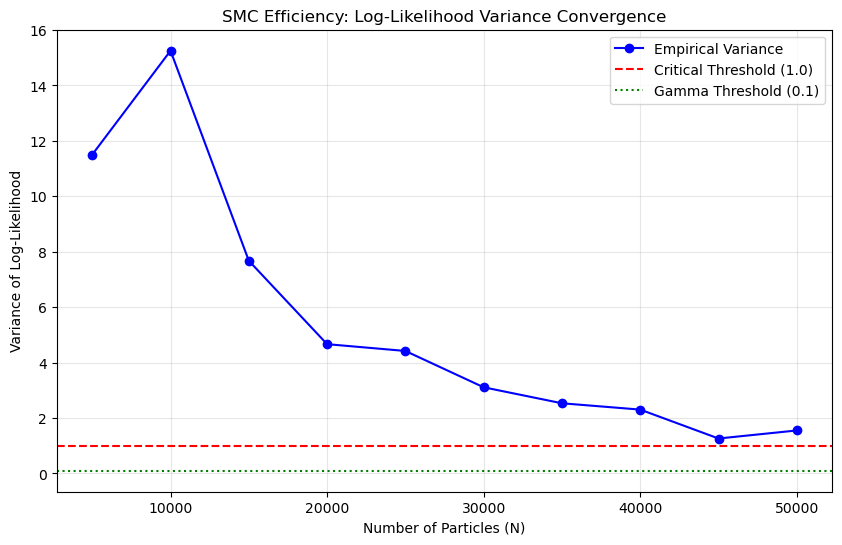

In [70]:
results = run_smc_convergence_study(np.linspace(5000, 50000, 10, dtype=int).tolist(), 20, annuals_fixed_params)

The variance study shows that increasing $N$ from 5,000 to 50,000 reduces numerical noise as expected, with the estimator reaching the 1.0 threshold at $N = 45,000$. This indicates that 45,000 particles is a suitable choice to ensure the PMMH acceptance step reflects the model fit rather than particle filter instability. However, it should be noted that the computational cost becomes significant with $N >20,000$, leading to substantially longer execution times.

## PMMH on SV Model

This PMMH focuses on estimating SV parameters by freezing jumps at zero to test the algorithm's recovery of diffusion dynamics from a naive start. Running 30,000 particles over 500 iterations is a computational trade-off: although our previous test showed a variance of 2.53 (exceeding the optimal $\text{Var} \ll 1$), increasing $N$ further would make the total execution time prohibitive. Following Dufays et al. (2022), we use a Logit-Normal prior to bound $\rho$ within $(-1, 1)$ and Uniform priors for other parameters to stay within economically sensible ranges. The proposal covariance is constructed by scaling the prior widths for Uniforms and the latent scale for the Logit-Normal, then refined via an adaptive mechanism to maintain exploration despite the numerical noise.

In [ ]:
def analyze_pmmh_run(pmmh_algo, burn_in_ratio=0.2):
    """
    Standardizes post-processing for PMMH runs.
    Extracts chain, removes burn-in, reports stats, and plots traces.
    
    Args:
        pmmh_algo: The executed PMMH object (from particles library).
        burn_in_ratio (float): Fraction of the chain to discard (0.0 to 1.0).
        
    Returns:
        pd.DataFrame: The cleaned posterior samples.
    """
    
    # 1. Performance Metric (Acceptance Rate)
    print(f"Final Acceptance Rate: {pmmh_algo.acc_rate:.2%}")
    
    # 2. Data Extraction
    # Convert structured array to DataFrame directly
    chain_data = pmmh_algo.chain.theta
    df_full = pd.DataFrame(chain_data)
    
    # 3. Burn-in Removal
    n_total = len(df_full)
    burn_in_idx = int(n_total * burn_in_ratio)
    df_posterior = df_full.iloc[burn_in_idx:].copy()
    
    print(f"Analysis based on {len(df_posterior)} posterior samples (Discarded first {burn_in_idx})")
    
    # 4. Visualization: Traceplots
    n_params = len(df_posterior.columns)
    
    # Dynamic figure size based on parameter count
    fig, axes = plt.subplots(nrows=n_params, ncols=1, figsize=(10, 2.5 * n_params), sharex=True)
    fig.suptitle('MCMC Traceplots (Convergence & Mixing)', fontsize=14, y=0.99)
    
    # Ensure axes is iterable even if there's only 1 parameter
    if n_params == 1:
        axes = [axes]
        
    for i, param in enumerate(df_posterior.columns):
        ax = axes[i]
        # Plot raw values
        ax.plot(df_posterior[param].values, lw=1.0, alpha=0.8)
        
        # Styling
        ax.set_ylabel(param, fontweight='bold')
        ax.grid(True, linestyle='--', alpha=0.6)
        
        # Add a visual mean line
        mean_val = df_posterior[param].mean()
        ax.axhline(mean_val, color='red', linestyle=':', alpha=0.5, label=f"Mean: {mean_val:.4f}")
        ax.legend(loc='upper right', fontsize='small')

    plt.xlabel("Iterations (Post Burn-in)")
    plt.tight_layout()
    plt.show()
    
    return df_posterior

In [ ]:
# No Jump parameters
fixed_jump_params = {
    'lbd': 0.0,
    'mu_s':  0.0,
    'sigma_s': 0.0,
    'mu_v':   0.0,
    'rho_j': 0.0,
    'delta':  0.0
}

In [62]:
# We use 'partial' to freeze the fixed parameters 
from functools import partial
SVCJ_Frozen = partial(
    SVCJ_Model, 
    r_vec=r_vector, 
    dt=dt, 
    **fixed_jump_params 
)

In [63]:
class LogitNormalBounded(dists.ProbDist):
    """
    Generalized Logit-Normal distribution on a bounded interval (a, b).
    
    Transformation:
        X = ln( (Y - a) / (b - Y) ) ~ Normal(loc, scale^2)
        
    This allows setting priors on parameters bounded in (a, b) by defining 
    a Normal belief on their logit transformation.
    
    Used in Dufays et al. (2022) for:
    - Rho (Correlation): a=-1, b=1
    - Lambda (Jump intensity): a=0.5, b=252
    
    Parameters
    ----------
    loc: float
        Mean of the underlying Normal distribution.
    scale: float
        Standard deviation of the underlying Normal distribution.
    a: float
        Lower bound of the physical parameter.
    b: float
        Upper bound of the physical parameter.
    """

    def __init__(self, loc=0.0, scale=1.0, a=0.0, b=1.0):
        self.loc = loc
        self.scale = scale
        self.a = a
        self.b = b

    def rvs(self, size=None):
        # 1. Sample X from Normal(loc, scale)
        x = random.normal(loc=self.loc, scale=self.scale, size=self.shape(size))
        
        # 2. Inverse transformation (Sigmoid scaled)
        # Y = a + (b - a) * (1 / (1 + exp(-x)))
        return self.a + (self.b - self.a) * (1.0 / (1.0 + np.exp(-x)))

    def logpdf(self, y):
        # Ensure array
        y = np.array(y)
        
        # 1. Bounds check
        out_of_bounds = (y <= self.a) | (y >= self.b)
        
        # 2. Numerical safety (clip slightly inside interval to avoid log(0))
        # We assume y is float64
        eps = 1e-9
        y_safe = np.clip(y, self.a + eps, self.b - eps)
        
        # 3. Transform to X space: X = ln( (y - a) / (b - y) )
        val_x = np.log((y_safe - self.a) / (self.b - y_safe))
        
        # 4. Log-density of X under Normal
        log_prob_x = stats.norm.logpdf(val_x, loc=self.loc, scale=self.scale)
        
        # 5. Jacobian Adjustment
        # dX/dY = (b - a) / ((y - a)(b - y))
        # Log-Jac = ln(b-a) - ln(y - a) - ln(b - y)
        jac = np.log(self.b - self.a) - np.log(y_safe - self.a) - np.log(self.b - y_safe)
        
        lp = log_prob_x + jac
        
        # Apply bounds mask
        if np.any(out_of_bounds):
             # Handle scalar vs vector nicely
            if lp.ndim == 0: return -np.inf
            lp[out_of_bounds] = -np.inf
            
        return lp

    def ppf(self, u):
        # Inverse CDF
        x = stats.norm.ppf(u, loc=self.loc, scale=self.scale)
        return self.a + (self.b - self.a) * (1.0 / (1.0 + np.exp(-x)))

In [ ]:
SV_prior_paper_bounded = dists.StructDist({
    # Diffusion parameters with flat (uninformative) priors
    # We bounded to avoid non sense values
    'kappa':   dists.Uniform(1.0, 10.0),#In the litterature never above 10 and above 1
    'theta':   dists.Uniform(0.0001, 0.2), #Litterature never above 0.05
    'sigma':   dists.Uniform(0.01, 1.5),#never above 1
    'eta_s':   dists.Uniform(0.0001, 5.0),#Risk premia >0
    'rho':     LogitNormalBounded(loc=-1.5, scale=0.5, a=-1.0, b=1.0),
})


In [ ]:
# Tuning parameter: 10%
gamma = 0.1

# Uniforms: Width (b - a)
# LogitNormals: The latent Scale
base_metrics = [
    9.0,         # kappa (Uniform): 10 - 1
    0.2,         # theta (Uniform): 0.2 - 0.0001
    1.5,         # sigma (Uniform): 1.5 - 0.01
    5.0,         # eta_s (Uniform): 5 - 0.0001
    
    0.5,         # rho (LogitNormal): we use the latent Scale (0.5)
]

# Compute the RW Variance
# Formula: Variance = (Base_Metric * gamma)^2
cov_diag = [(val * gamma)**2 for val in base_metrics]

# Create Matrix
rw_cov_sv = np.diag(cov_diag)

In [ ]:
# PMMH Algorithm Setup
n_particles = 30000  # Particle count for variance control
n_iterations = 500

pmmh_algorithm_est_theta_SV_Naive_ini_bounded = mcmc.PMMH(
    ssm_cls=SVCJ_Frozen,  
    prior=SV_prior_paper_bounded,           # Parameters to be estimated
    data=data_y,               # Log returns data
    Nx=n_particles,                  # Number of particles for likelihood estimation
    smc_options={              # Internal Particle Filter settings
        'resampling': 'systematic',
        'ESSrmin': 0.5,
        'store_history': False
    },
    niter=n_iterations,
    adaptive = True,
    rw_cov = rw_cov_sv,
    verbose = 100
)
pmmh_algorithm_est_theta_SV_Naive_ini_bounded.run()

Iteration 0, eta_s=3.782922818165895, kappa=6.616800512505502, rho=-0.5252657932790369, sigma=1.2770590914142508, theta=0.03711774410974198
Iteration 5, acc. rate=0.400, eta_s=3.202630784305023, kappa=5.231215109101668, rho=-0.41222152919766264, sigma=0.602080214756331, theta=0.014978975569119618
Iteration 10, acc. rate=0.300, eta_s=3.1504968234148967, kappa=4.910244835290954, rho=-0.3938892555758739, sigma=0.602024485669468, theta=0.03386796109233541
Iteration 15, acc. rate=0.467, eta_s=3.213593066969375, kappa=5.02796037470876, rho=-0.40535985983097644, sigma=0.5322806887986978, theta=0.032508011464277224
Iteration 20, acc. rate=0.450, eta_s=3.288738463048434, kappa=5.119854927180367, rho=-0.4265083807640296, sigma=0.3960265758173618, theta=0.02615246604115607
Iteration 25, acc. rate=0.440, eta_s=3.625491225720768, kappa=5.583865955390162, rho=-0.47145755231574965, sigma=0.4905643436041533, theta=0.032277766385463376
Iteration 30, acc. rate=0.433, eta_s=3.7522353735712395, kappa=5.68

In [89]:
joblib.dump(pmmh_algorithm_est_theta_SV_Naive_ini_bounded, 'pmmh_jump_sv_results.pkl')

['pmmh_jump_sv_results.pkl']

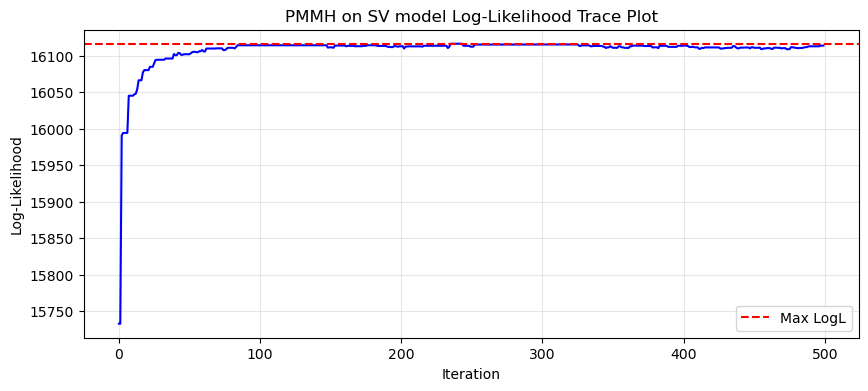

In [99]:
log_likelihoods = pmmh_algorithm_est_theta_SV_Naive_ini_bounded.chain.lpost

plt.figure(figsize=(10, 4))
plt.plot(log_likelihoods, color='Blue')
plt.axhline(y=np.max(log_likelihoods), color='red', linestyle='--', label='Max LogL')
plt.title('PMMH on SV model Log-Likelihood Trace Plot')
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Final Acceptance Rate: 29.66%
Analysis based on 400 posterior samples (Discarded first 100)


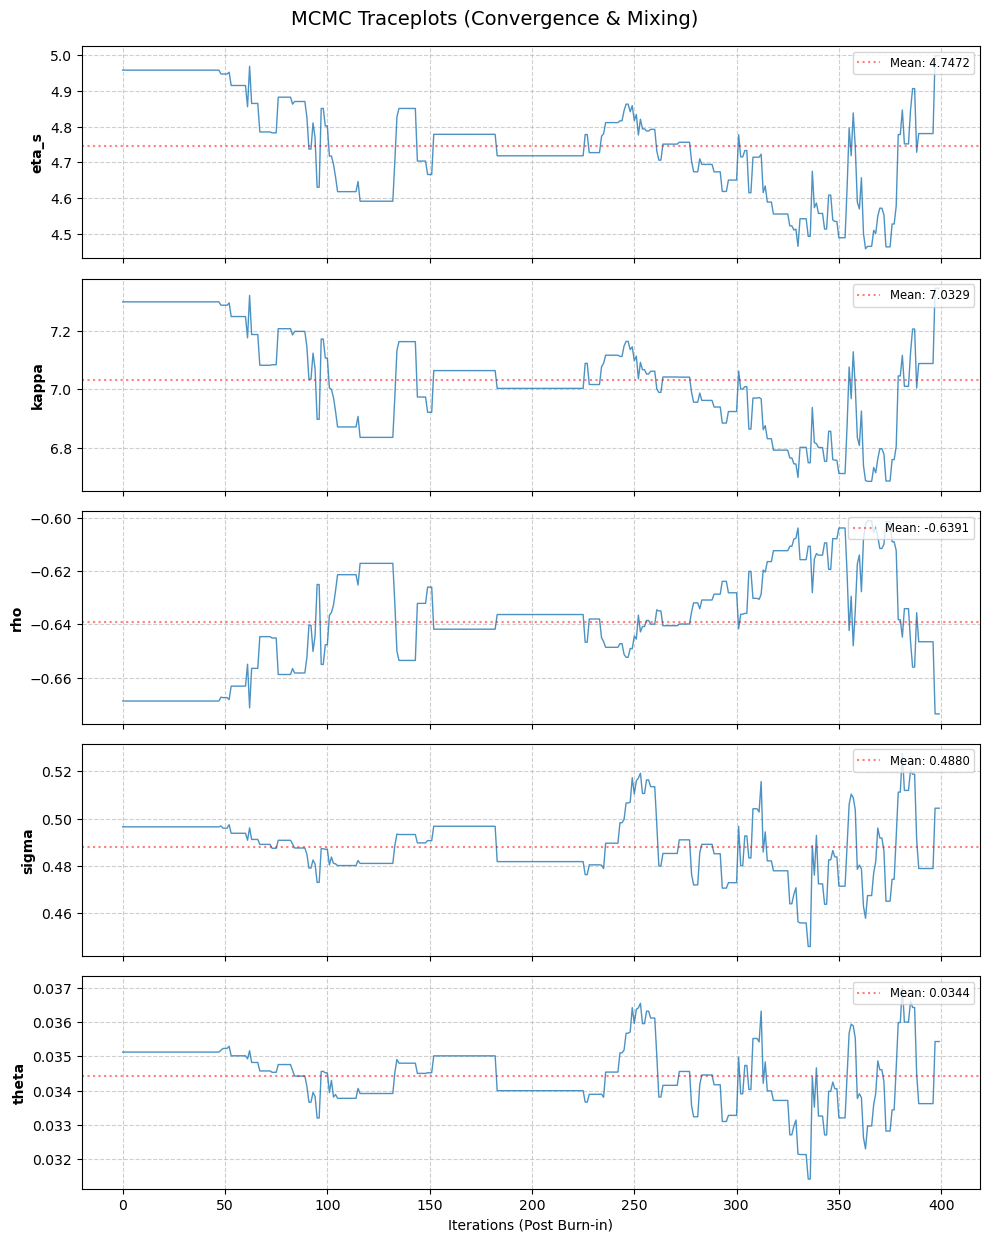

In [67]:
df_sv_naive_ini=analyze_pmmh_run(pmmh_algorithm_est_theta_SV_Naive_ini_bounded,burn_in_ratio=0.2)

We assess the SV model's fit by calculating the log-likelihood at the posterior mean, excluding the burn-in. Running 20 independent filters at this point quantifies the approximation error and verifies if the estimated parameters align with the benchmark results.

In [ ]:
# Extraction of theta found with PMMH
# We calculate the mean of the posterior distributions (discarding burn-in)
theta_pmmh = df_sv_naive_ini.mean().to_dict()
theta_pmmh={**theta_pmmh, **fixed_jump_params}

# Particle Filter setup for variance estimation
n_runs = 20
n_particles_test = 30000

# Bootstrap
model_validation = SVCJ_Model(r_vec=r_vector, dt=dt, **theta_pmmh)
fk_validation = ssm.Bootstrap(ssm=model_validation, data=data_y)

# Execution of multiSMC to assess the approximation error
results = multiSMC(
    fk=fk_validation,
    N=n_particles_test,
    nruns=n_runs,
    nprocs=4,
    resampling='systematic', 
    ESSrmin=0.5,
    out_func=lambda pf: pf.logLt 
)

# Statistical metrics extraction
log_likelihoods = [res['output'] for res in results]
variance_log_lik = np.var(log_likelihoods)
mean_log_lik = np.mean(log_likelihoods)
print(f"Mean Log-Likelihood:  {mean_log_lik:.4f}")
print(f"Variance : {variance_log_lik:.4f}")

Mean Log-Likelihood:  16113.5118
Variance : 1.0660


The run achieved a mean log-likelihood of 16,113.51, slightly lower than the Table A1 benchmark but within a consistent range. Crucially, our variance of 1.0660 is significantly lower than the 3.5106 obtained with the paper's parameters, suggesting a more stable likelihood surface. The final acceptance rate of 29.66% sits well within the optimal [23.4%, 44%] interval, confirming that the proposal distribution effectively explored the posterior despite the structural noise of the particle filter.

## PMMH SVCJ with fixed SV params

This Partial PMMH isolates the jump components by fixing the diffusion parameters to the previously validated SV posterior means. Following the methodology of Dufays et al. (2022), we use Logit-Normal priors for $\lambda$ and $\rho_j$ alongside bounded Uniform priors for jump sizes to specifically capture the return discontinuities that the continuous model ignores. The proposal covariance is manually tuned by scaling characteristic prior sizes by 10%, ensuring a balanced exploration of the jump-related subspace during the adaptive phase. We maintain the same computational trade-off of 30,000 particles over 500 iterations. 

In [ ]:
# Jumps SVCJ Prior
prior_jump = dists.StructDist({    
    # Jump Block: Flat priors over physical supports (Dufays Section 3.2)
    'lbd':     LogitNormalBounded(loc=-6.0, scale=1.0, a=0.5, b=252.0), # Annual intensity
    'rho_j':   LogitNormalBounded(loc=-0.5, scale=0.5, a=-1.0, b=1.0),
    'mu_s':      dists.Uniform(a=np.negative(0.2), b=0.0), 
    'sigma_s':   dists.Uniform(a=0.0001, b=0.2), 
    'mu_v':      dists.Uniform(a=0.0001, b=0.3)  # Vol jump size
})

In [76]:
# Extract means from naive SV run
sv_fixed_params = df_sv_naive_ini.mean().to_dict()

# Fix the model with these SV parameters
SVCJ_Jump_Only = partial(
    SVCJ_Model, 
    r_vec=r_vector, 
    dt=dt,
    delta=0.0,
    **sv_fixed_params
)


In [ ]:
# Tuning parameter: 10%
gamma = 0.1

# Definition of Base Metrics
# Uniforms: Width (b - a)
# LogitNormals: The latent Scale
base_metrics = [
    1.0,         # lbd (LogitNormal): we use the latent Scale (1.0)
    0.5,         # rho_j (LogitNormal): we use the latent Scale (0.5)
    
    0.2,         # mu_s (Uniform): 0 - (-0.2)
    0.2,         # sigma_s (Uniform): 0.2 - 0.0001
    0.3          # mu_v (Uniform): 0.3 - 0.0001
]

# Compute the RW Variance
# Formula: Variance = (Base_Metric * gamma)^2
cov_diag = [(val * gamma)**2 for val in base_metrics]

# Create Matrix
rw_cov_jump = np.diag(cov_diag)

In [78]:
# PMMH Execution Setup
n_particles = 30000  
n_iterations = 500

pmmh_jump = mcmc.PMMH(
    ssm_cls=SVCJ_Jump_Only,
    prior=prior_jump,
    data=data_y,
    Nx=n_particles,
    smc_options={
        'resampling': 'systematic',
        'ESSrmin': 0.5,
        'store_history': False
    },
    niter=n_iterations,
    adaptive=True,
    verbose=100,
    rw_cov=rw_cov_jump
)
pmmh_jump.run()

Iteration 0, lbd=1.9704547937660022, mu_s=-0.05803549502611499, mu_v=0.25391260086737294, rho_j=-0.2624309743366895, sigma_s=0.11092179570063192
Iteration 5, acc. rate=0.200, lbd=1.7796239427221656, mu_s=-0.044135130324391175, mu_v=0.24195958484182678, rho_j=-0.23825412110262134, sigma_s=0.0946173729992912
Iteration 10, acc. rate=0.400, lbd=1.3335682014204189, mu_s=-0.03847537583282407, mu_v=0.19055451669085868, rho_j=-0.16958163587349942, sigma_s=0.07204188910059606
Iteration 15, acc. rate=0.400, lbd=1.1182261667711832, mu_s=-0.035087402417185845, mu_v=0.16605178738390786, rho_j=-0.1377799965521196, sigma_s=0.05829036961049478
Iteration 20, acc. rate=0.400, lbd=0.6060792566803708, mu_s=-0.019834120064339166, mu_v=0.10489444500674835, rho_j=-0.06660477379799268, sigma_s=0.029324363333683427
Iteration 25, acc. rate=0.320, lbd=0.6060792566803708, mu_s=-0.019834120064339166, mu_v=0.10489444500674835, rho_j=-0.06660477379799268, sigma_s=0.029324363333683427
Iteration 30, acc. rate=0.267, l

In [ ]:
joblib.dump(pmmh_jump, 'pmmh_jump_svcj_results.pkl')

['pmmh_jump_svcj_results.pkl']

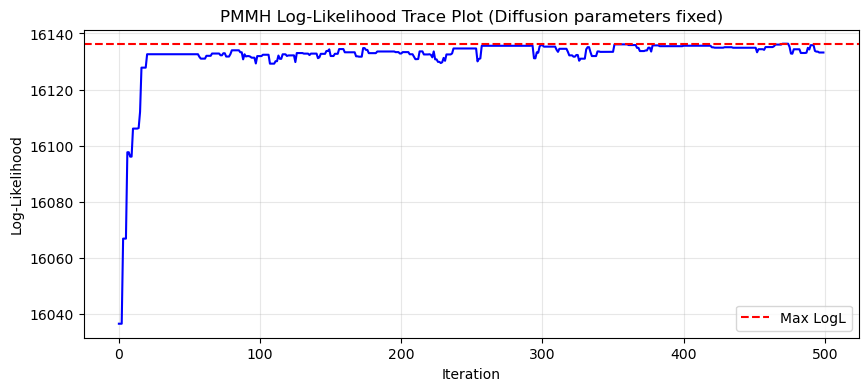

In [87]:
log_likelihoods = pmmh_jump.chain.lpost

plt.figure(figsize=(10, 4))
plt.plot(log_likelihoods, color='Blue')
plt.axhline(y=np.max(log_likelihoods), color='red', linestyle='--', label='Max LogL')
plt.title('PMMH Log-Likelihood Trace Plot (Diffusion parameters fixed)')
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Final Acceptance Rate: 28.06%
Analysis based on 400 posterior samples (Discarded first 100)


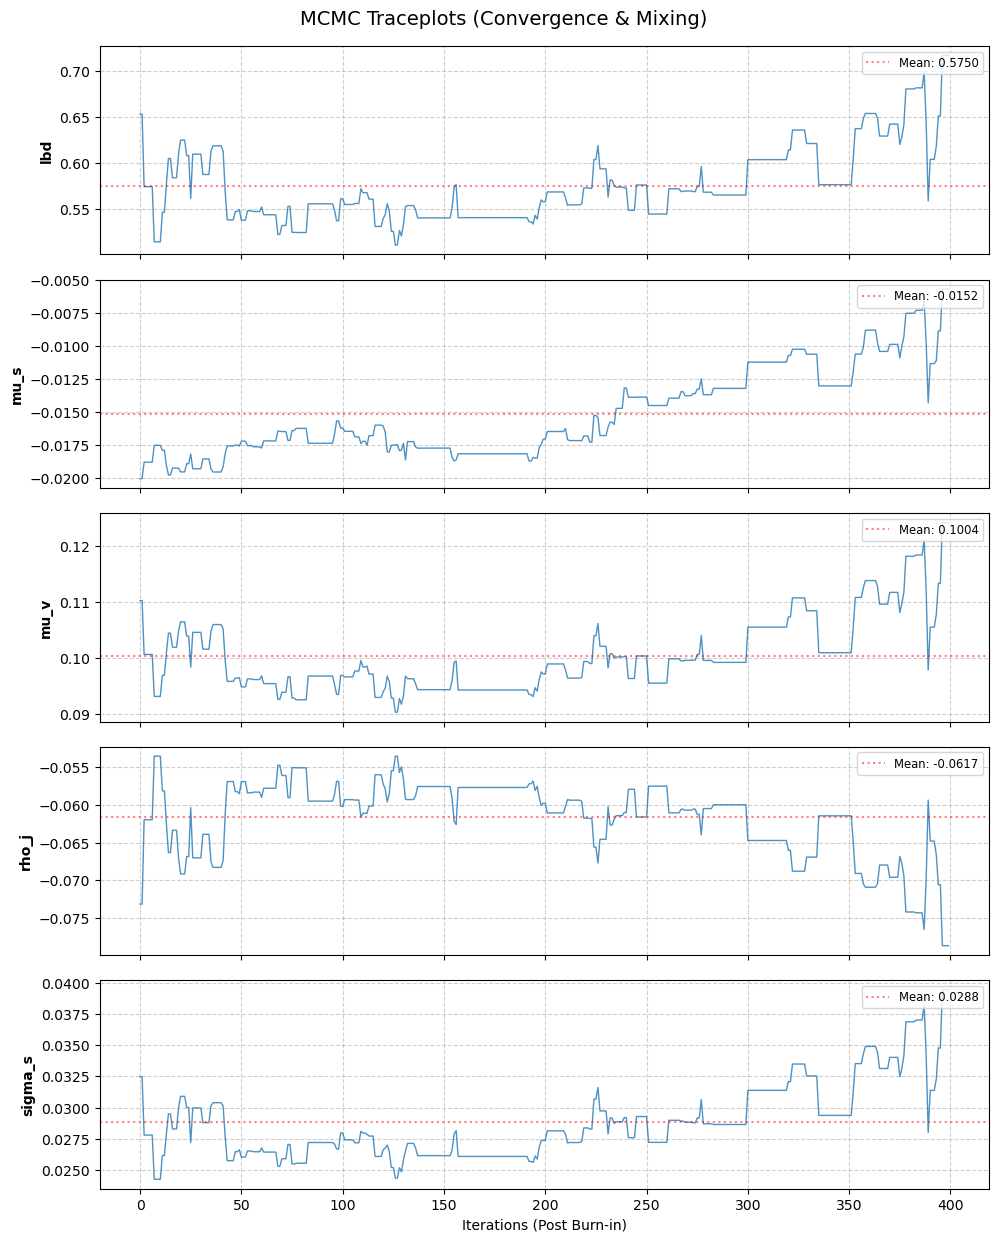

In [80]:
df_sv_jump=analyze_pmmh_run(pmmh_jump,burn_in_ratio=0.2)

As before, we calculate the log-likelihood at the posterior mean (excluding burn-in) 20 times to validate the jump estimation.

In [81]:
# Extraction of theta found with PMMH
# We calculate the mean of the posterior distributions (discarding burn-in)
theta_pmmh = df_sv_jump.mean().to_dict()
theta_pmmh={**theta_pmmh, **sv_fixed_params, 'delta':  0.0}

# Particle Filter setup for variance estimation
n_runs = 20
n_particles_test = 30000

# Bootstrap
model_validation = SVCJ_Model(r_vec=r_vector, dt=dt, **theta_pmmh)
fk_validation = ssm.Bootstrap(ssm=model_validation, data=data_y)

# Execution of multiSMC to assess the approximation error
results = multiSMC(
    fk=fk_validation,
    N=n_particles_test,
    nruns=n_runs,
    nprocs=4,
    resampling='systematic', 
    ESSrmin=0.5,
    out_func=lambda pf: pf.logLt 
)

# Statistical metrics extraction
log_likelihoods = [res['output'] for res in results]
variance_log_lik = np.var(log_likelihoods)
mean_log_lik = np.mean(log_likelihoods)
print(f"Mean Log-Likelihood:  {mean_log_lik:.4f}")
print(f"Variance : {variance_log_lik:.4f}")

Mean Log-Likelihood:  16128.7147
Variance : 2.0912


The resulting log-likelihood of 16,128.72 confirms a successful transition from a naive starting point to a high-density region, outperforming the pure SV model by approximately 16 points. This gain demonstrates that the jump components are statistically essential for capturing the S&P 500's tail behavior.

Crucially, the estimator's variance dropped to 2.1, which is lower than the variance observed when using the paper's original parameters (~3.5). This indicates that our current parameter set is better "tuned" to the specific noise of this dataset, providing a more stable likelihood surface.

## PMMH on full SVCJ Parameters

We consolidate the validated posterior means from the separate SV and Jump runs to initialize the full SVCJ model. This "warm start" strategy avoids we avoid a random start that could cause the algorithm to get stuck in a local maximum or waste iterations exploring low-density regions of the 10-dimensional parameter space. To maintain the chain's exploration efficiency, we construct a block-diagonal Proposal Covariance Matrix by merging the learned covariance structures from the previous partial runs.

Given the increased complexity of the 10-parameter space and the high dimensionality of the state vector, we increase the particle count to 40,000, while still keeping the 500-iteration runtime manageable.

In [82]:
# SVCJ Prior
full_prior_article = dists.StructDist({
    # Diffusion Block
    'kappa':   dists.Uniform(1.0, 10.0),#In the litterature never above 10 and above 1
    'theta':   dists.Uniform(0.0001, 0.2), #Litterature never above 0.05
    'sigma':   dists.Uniform(0.01, 1.5),#never above 1
    'eta_s':   dists.Uniform(0.0001, 5.0),#Risk premia >0
    'rho':     LogitNormalBounded(loc=-1.5, scale=0.5, a=-1.0, b=1.0),
    
    # Jump Block
    'lbd':     LogitNormalBounded(loc=-6.0, scale=1.0, a=0.5, b=252.0), # Annual intensity
    'rho_j':   LogitNormalBounded(loc=-0.5, scale=0.5, a=-1.0, b=1.0),
    'mu_s':      dists.Uniform(a=np.negative(0.2), b=0.0), 
    'sigma_s':   dists.Uniform(a=0.0001, b=0.2), 
    'mu_v':      dists.Uniform(a=0.0001, b=0.3)  # Vol jump size
})

In [83]:
# Fixed model definition with delta=0.0
SVCJ_Full = partial(
    SVCJ_Model, 
    r_vec=r_vector, 
    dt=dt,
    delta=0.0
)

sv_means = df_sv_naive_ini.mean()
jump_means = df_sv_jump.mean()
theta0_SV = {
    'kappa':   sv_means['kappa'],
    'theta':   sv_means['theta'],
    'sigma':   sv_means['sigma'],
    'rho':     sv_means['rho'],
    'eta_s':   sv_means['eta_s']
}
safe_jumps = {
    'lbd':     jump_means['lbd'],
    'rho_j':   jump_means['rho_j'],
    'mu_s':    jump_means['mu_s'],
    'sigma_s': jump_means['sigma_s'],
    'mu_v':    jump_means['mu_v']
}

theta0_init = np.zeros(1, dtype=full_prior_article.dtype)

for key, value in theta0_SV.items():
    theta0_init[key] = value

for key, value in safe_jumps.items():
    theta0_init[key] = value
theta0_init

array([(4.74715596, 7.03286918, 0.57497929, -0.01517489, 0.10038768, -0.63912926, -0.06165145, 0.48803394, 0.02880537, 0.03442299)],
      dtype=[('eta_s', '<f8'), ('kappa', '<f8'), ('lbd', '<f8'), ('mu_s', '<f8'), ('mu_v', '<f8'), ('rho', '<f8'), ('rho_j', '<f8'), ('sigma', '<f8'), ('sigma_s', '<f8'), ('theta', '<f8')])

In [84]:
# Retrieve estimated covariance matrices from previous PMMH runs
cov_sv = pmmh_algorithm_est_theta_SV_Naive_ini_bounded.cov_tracker.Sigma
cov_jump = pmmh_jump.cov_tracker.Sigma

# Initialize global 10x10 matrix (Alphabetical order: eta_s, kappa, lbd, mu_s, mu_v, rho, rho_j, sigma, sigma_s, theta)
full_rw_cov = np.zeros((10, 10))

# Map SV diffusion block (old_idx -> global_idx)
sv_map = {0: 0, 1: 1, 2: 5, 3: 7, 4: 9}
for i, new_i in sv_map.items():
    for j, new_j in sv_map.items():
        full_rw_cov[new_i, new_j] = cov_sv[i, j]

# Map Jump block (old_idx -> global_idx)
jump_map = {0: 2, 1: 3, 2: 4, 3: 6, 4: 8}
for i, new_i in jump_map.items():
    for j, new_j in jump_map.items():
        full_rw_cov[new_i, new_j] = cov_jump[i, j]

# Numerical stabilization of the covariance matrix
full_rw_cov += np.eye(10) * 1e-8

In [ ]:
# PMMH Execution Setup
n_particles = 40000  
n_iterations = 500

pmmh_full_unif = mcmc.PMMH(
    ssm_cls=SVCJ_Full,
    prior=full_prior_article,
    data=data_y,
    Nx=n_particles,
    smc_options={
        'resampling': 'systematic',
        'ESSrmin': 0.5,
        'store_history': False
    },
    niter=n_iterations,
    adaptive=True,
    verbose=100,
    theta0=theta0_init,
    rw_cov=full_rw_cov
)
pmmh_full_unif.run()

Iteration 0, eta_s=4.641100208661296, kappa=6.872904788922317, lbd=0.5816467469620653, mu_s=-0.013170123677371158, mu_v=0.10132684473405733, rho=-0.6271907838780759, rho_j=-0.06269932243510695, sigma=0.46620202816721695, sigma_s=0.02974938956205235, theta=0.03275339976848906
Iteration 5, acc. rate=0.000, eta_s=4.641100208661296, kappa=6.872904788922317, lbd=0.5816467469620653, mu_s=-0.013170123677371158, mu_v=0.10132684473405733, rho=-0.6271907838780759, rho_j=-0.06269932243510695, sigma=0.46620202816721695, sigma_s=0.02974938956205235, theta=0.03275339976848906
Iteration 10, acc. rate=0.200, eta_s=4.748870898082853, kappa=7.029777873604473, lbd=0.594845832499176, mu_s=-0.013387289820625356, mu_v=0.10359242140938003, rho=-0.6420378402143915, rho_j=-0.06415617339891952, sigma=0.4753471468116893, sigma_s=0.030447241388233716, theta=0.0333640624911163
Iteration 15, acc. rate=0.333, eta_s=4.600176012113593, kappa=6.814223837297823, lbd=0.581650884104762, mu_s=-0.012781712447046486, mu_v=0.

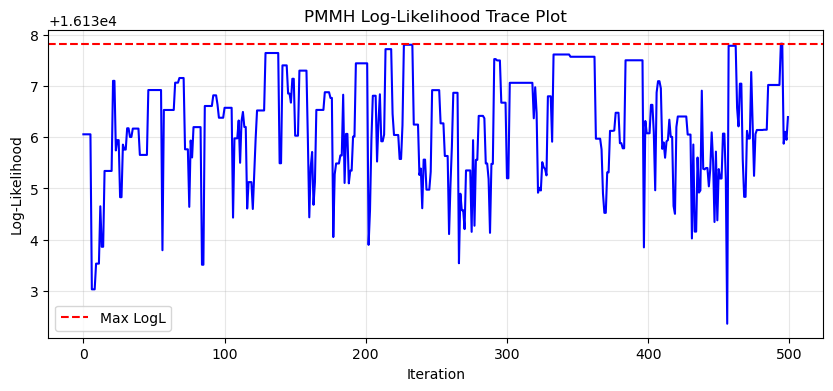

In [91]:
log_likelihoods = pmmh_full_unif.chain.lpost

plt.figure(figsize=(10, 4))
plt.plot(log_likelihoods, color='Blue')
plt.axhline(y=np.max(log_likelihoods), color='red', linestyle='--', label='Max LogL')
plt.title('PMMH Log-Likelihood Trace Plot')
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

The PMMH sampler fails to climb beyond its initialization, stagnating at 16,132.44 without reaching the 16,160.82 benchmark. The persistent staircase pattern in the trace plot confirms the inability to navigate the 10D manifold or escape the local mode.

In [95]:
joblib.dump(pmmh_full_unif, 'pmmh_full_svcj_results.pkl')

['pmmh_full_svcj_results.pkl']

Final Acceptance Rate: 41.88%
Analysis based on 400 posterior samples (Discarded first 100)


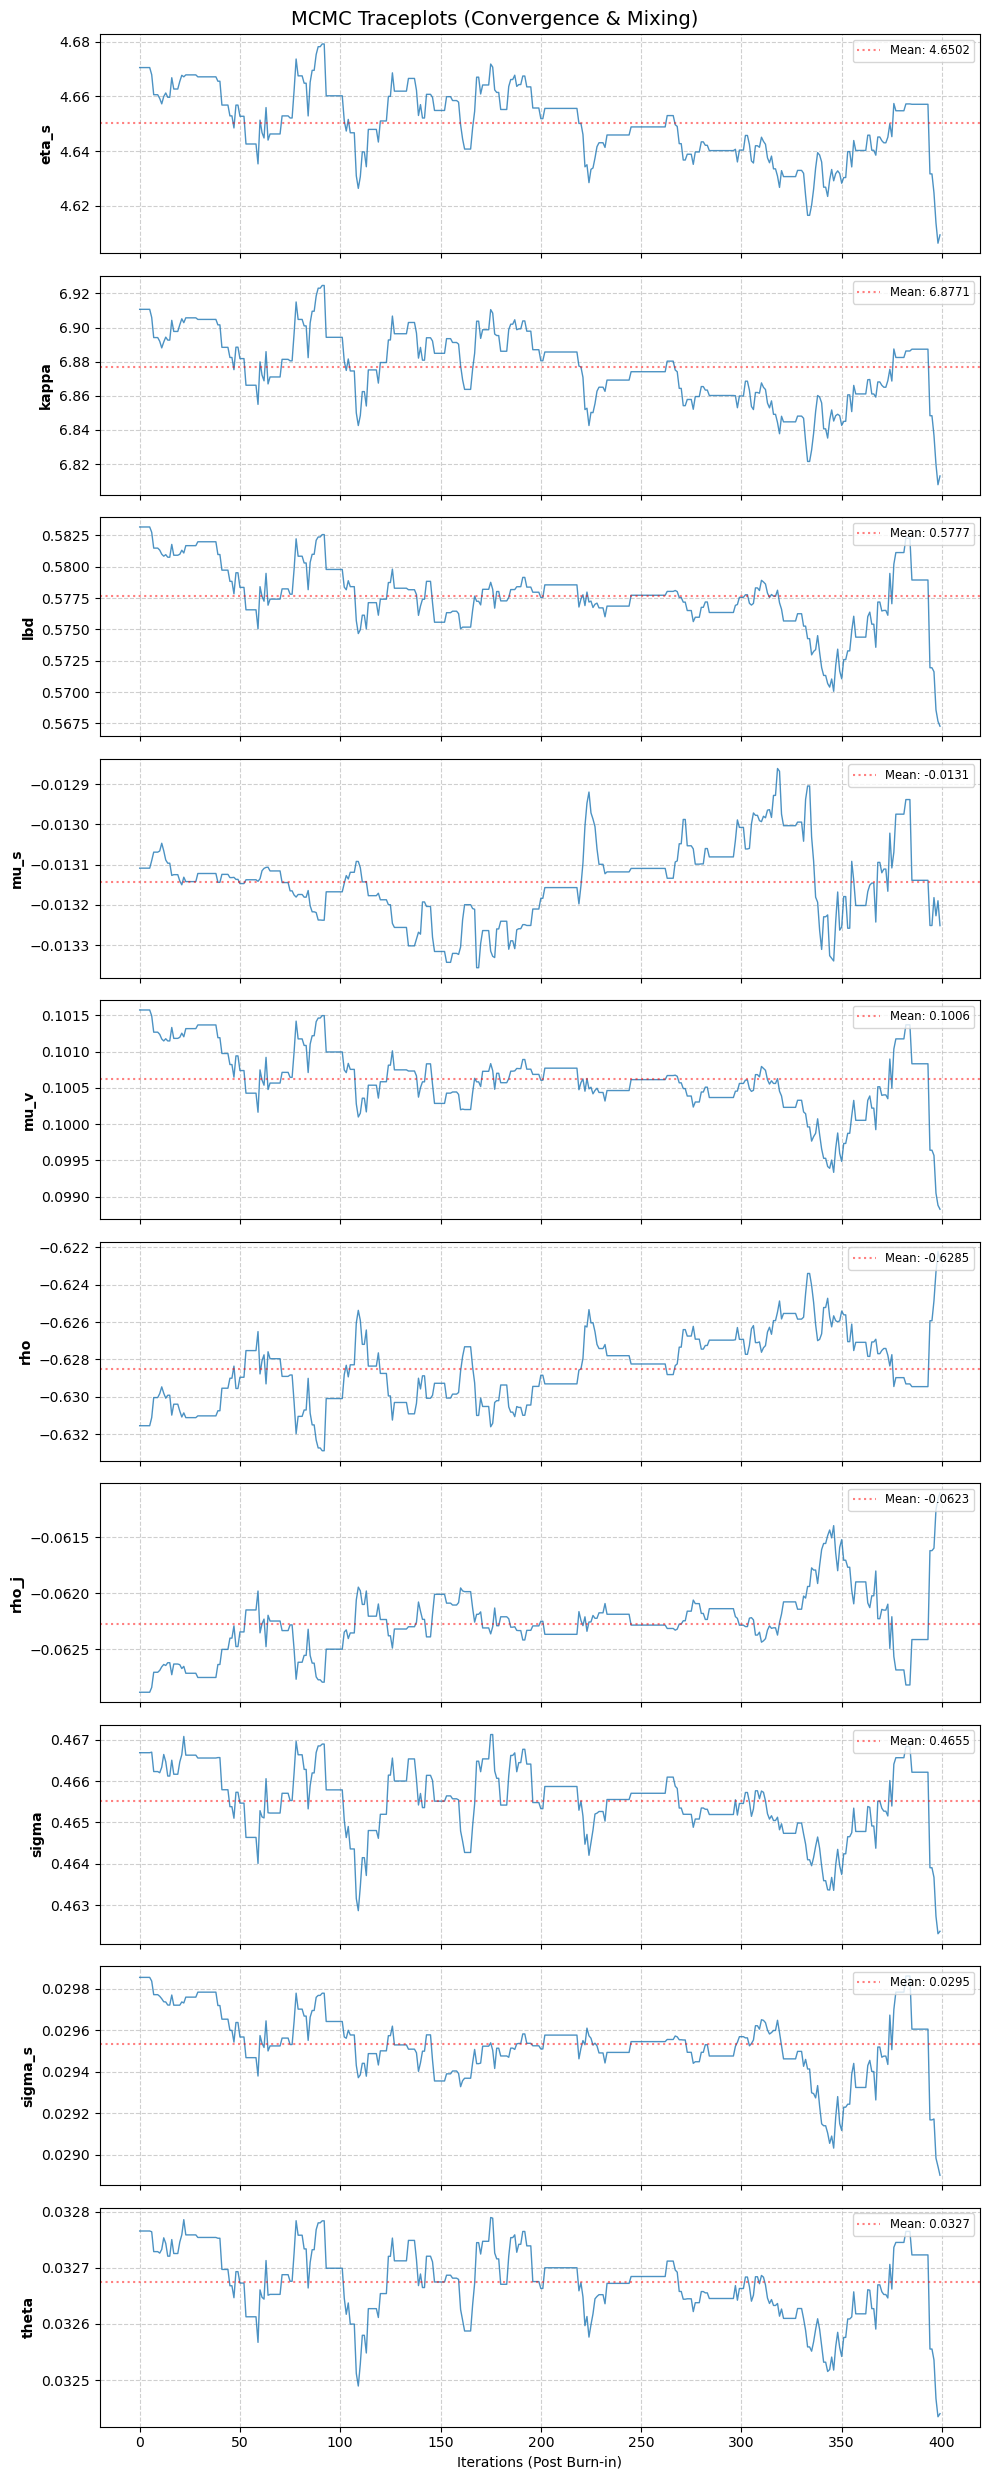

In [92]:
df_full=analyze_pmmh_run(pmmh_full_unif)

As before, we calculate the log-likelihood at the posterior mean (excluding burn-in) 20 times to validate the parameters estimation.

In [93]:
# Extraction of theta found with PMMH
theta_pmmh = df_full.mean().to_dict()
theta_pmmh['delta'] = 0.0

# Particle Filter setup for variance estimation
n_runs = 20
n_particles_test = 30000

# Bootstrap
model_validation = SVCJ_Model(r_vec=r_vector, dt=dt, **theta_pmmh)
fk_validation = ssm.Bootstrap(ssm=model_validation, data=data_y)

# Execution of multiSMC to assess the approximation error
results = multiSMC(
    fk=fk_validation,
    N=n_particles_test,
    nruns=n_runs,
    nprocs=4,
    resampling='systematic', 
    ESSrmin=0.5,
    out_func=lambda pf: pf.logLt 
)

# Statistical metrics extraction
log_likelihoods = [res['output'] for res in results]
variance_log_lik = np.var(log_likelihoods)
mean_log_lik = np.mean(log_likelihoods)
print(f"Mean Log-Likelihood:  {mean_log_lik:.4f}")
print(f"Variance : {variance_log_lik:.4f}")

Mean Log-Likelihood:  16132.4435
Variance : 1.6790



The joint PMMH estimation achieves a Mean Log-Likelihood of 16,132.44. While this outperforms the SVCJ configuration with fixed jump parameters (16,128.72), it remains significantly below the 16,160.82 article benchmark. 

Our variance of 1.6790 confirms a much more stable likelihood surface compared to the article's benchmark of 5.0186. However, this variance remains strictly greater than 1, falling short of the optimal stability threshold $\mathrm{Var}(\log \hat{p}_\theta(y_{1:T})) \ll 1$ required for efficient MCMC mixing in high-dimensional spaces. 

Although increasing the particle count  is theoretically necessary to reach the unit threshold, it is computationally unfeasible for our current setup. The current run (500 iterations with $N=40,000$) required 8 hours of computation and caused frequent kernel crashes, making any further scaling of $N$ or chain length practically impossible under these hardware limitations.